# FINAL MODEL FUNCTION

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [4]:
# Reading Files
df = pd.read_csv('Hotel Reservations.csv')

In [5]:
# Convert categorical variables to dummies and append to df 
dummy_market = pd.get_dummies(df.market_segment_type)
dummy_month = pd.get_dummies(df.arrival_month)
dummy_meal = pd.get_dummies(df.type_of_meal_plan)
dummy_room = pd.get_dummies(df.room_type_reserved)

# Add dummy variables to df and drop 1 to avoid perfect multicollinearity in model 
df_dummy = pd.concat([df, dummy_market.drop('Aviation', axis = 1), dummy_month.drop(4, axis = 1), dummy_meal.drop('Meal Plan 3', axis = 1), dummy_room.drop('Room_Type 7', axis = 1)], axis = 1)
df_dummy.columns = df_dummy.columns.astype(str)

# Remove spaces from column names 
df_dummy.columns = df_dummy.columns.str.replace(' ', '')

# Convert month number to name in columns 
df_dummy.rename(columns={'1': 'January', '2': 'February', '3': 'March', 
                         '5': 'May', '6': 'June', '7': 'July', 
                        '8': 'August', '9': 'September', '10': 'October',
                        '11': 'November', '12': 'December'}, inplace=True)

df_dummy['booking_status'] = df_dummy['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0})

In [6]:
# Split train and test data 
train, test = train_test_split(df_dummy, test_size=0.25, random_state=25, shuffle=True)
# train['booking_status'] = train['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0})
# test['booking_status'] = test['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0})

In [7]:
# Model 1) Baseline Model
logit_model = sm.logit(formula = 'booking_status ~ no_of_adults + no_of_children  + no_of_weekend_nights + no_of_week_nights + type_of_meal_plan + required_car_parking_space + room_type_reserved +lead_time  + market_segment_type +repeated_guest + no_of_previous_cancellations + avg_price_per_room  + no_of_special_requests', data = train).fit()

#Predict the values using the Logit model
pred_values_1 = logit_model.predict(test)

pred_values_1

         Current function value: 0.422758
         Iterations: 35


/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


28112    0.550674
6482     0.104302
12183    0.068526
34739    0.059497
2375     0.807306
           ...   
28804    0.182722
9727     0.099403
36076    0.656581
25340    0.160407
34948    0.064998
Length: 9069, dtype: float64

In [8]:
len(pred_values_1)

9069

In [9]:
# Model 2) EDA-Based Logit Model 
eda_model = sm.logit('booking_status ~ np.log(lead_time+1) + np.log(avg_price_per_room+1) + no_of_special_requests', data = train).fit()

#Predict the values using the EDA-Based Logit model
pred_values_2 = eda_model.predict(test)

pred_values_2

Optimization terminated successfully.
         Current function value: 0.478240
         Iterations 7


28112    0.469041
6482     0.398107
12183    0.087991
34739    0.074100
2375     0.613424
           ...   
28804    0.208027
9727     0.450944
36076    0.634002
25340    0.503493
34948    0.272606
Length: 9069, dtype: float64

In [10]:
# Model 3) Forward/Backward Selection Model (Produced same model with 18 predictors based on BIC criterion)

# Continuous and categorical predictors (except market_segment_type, type_of_meal_plan, room_type_reserved)
X = train[['no_of_adults', 'no_of_children','no_of_weekend_nights','no_of_week_nights',
           'required_car_parking_space','lead_time','arrival_year','arrival_date','repeated_guest', 
           'no_of_previous_cancellations','no_of_previous_bookings_not_canceled','avg_price_per_room', 
           'no_of_special_requests', 'January','February', 'March', 'May', 'June', 'July', 
           'August', 'September','October', 'November', 'December']]

#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate BIC
    model = sm.logit('booking_status~' + '+'.join(predictor_subset), data = train).fit()
    BIC = model.bic
    return {"model":model, "BIC":BIC}

#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest BIC
    best_model = models.loc[models['BIC'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["BIC", "model"])

    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    return models_best

models_best = forward_selection()

# def best_sub_plots():
#     plt.figure(figsize=(20,10))
#     plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

#     # Set up a 2x2 grid so we can look at 4 plots at once
#     plt.subplot(2, 2, 1)


#     # AIC and BIC 
#     aic = models_best.apply(lambda row: row[1].aic, axis=1)

#     plt.subplot(2, 2, 1)
#     plt.plot(aic)
#     plt.plot(1+aic.argmin(), aic.min(), "or")
#     plt.xlabel('# Predictors')
#     plt.ylabel('AIC')

#     bic = models_best.apply(lambda row: row[1].bic, axis=1)

#     plt.subplot(2, 2, 2)
#     plt.plot(bic)
#     plt.plot(1+bic.argmin(), bic.min(), "or")
#     plt.xlabel('# Predictors')
#     plt.ylabel('BIC')

# best_sub_plots()

best_forward_model = models_best.loc[18,'model']

#Predict the values using the best Forward/Backward model
pred_values_3 = best_forward_model.predict(test)

pred_values_3

Optimization terminated successfully.
         Current function value: 0.627206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613451
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.631083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622996
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.630324
 

Optimization terminated successfully.
         Current function value: 0.468742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461682
  

Optimization terminated successfully.
         Current function value: 0.449608
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.450366
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.449956
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.446986
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.447981
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.447298
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.447974
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.446665
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.448016
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.443283
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.443046
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.443139
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442714
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442682
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442544
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442722
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.442494
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442570
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

28112    0.215077
6482     0.354784
12183    0.033234
34739    0.193879
2375     0.684184
           ...   
28804    0.020365
9727     0.224258
36076    0.642994
25340    0.500306
34948    0.151036
Length: 9069, dtype: float64

In [11]:
# Model 4) KNN

# Split train and test datasets
y = df_dummy.booking_status
X = df_dummy.drop(['booking_status', 'Booking_ID', 'type_of_meal_plan', 'market_segment_type', 'arrival_month', 'room_type_reserved'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)

# KNN with all predictors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train, y_train)

#Predict the values using the KNN model
pred_values_4 = knn.predict(X_test)
pred_values_4

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([1, 1, 1, ..., 0, 0, 0])

In [12]:
pred = knn.predict_proba(X_test)
len(pred)

9069

In [13]:
# Model 5) KNN + Variable Selection 

# KNN with 18 features selected from forward/backward selection 
y = df_dummy.booking_status
X = df_dummy[['no_of_adults', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space',
            'lead_time', 'arrival_year', 'repeated_guest', 'no_of_previous_cancellations', 
            'avg_price_per_room', 'no_of_special_requests', 'December', 'January',
             'June', 'September', 'May', 'February', 'November', 'March']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)
knn_var = KNeighborsClassifier().fit(X_train, y_train)

#Predict the values using the KNN +variable selection model
pred_values_5 = knn_var.predict(X_test)
pred_values_5

/Users/linhnganguyen/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([0, 1, 1, ..., 1, 0, 0])

In [14]:
# Model 6) Ridge

y = train.booking_status

#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
X = train.loc[:,['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space','lead_time', 'arrival_year', 
       'arrival_date', 'repeated_guest','no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'Complementary', 'Corporate', 
        'Offline', 'Online', 'January','February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2','NotSelected', 
        'Room_Type1', 'Room_Type2', 'Room_Type3', 'Room_Type4','Room_Type5', 'Room_Type6']]

#Defining a scaler object
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

#Filtering all predictors in test dataset
Xtest = test.loc[:,['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space',
       'lead_time', 'arrival_year', 'arrival_date', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 
       'Complementary', 'Corporate', 'Offline', 'Online', 'January',
       'February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2',
       'NotSelected', 'Room_Type1', 'Room_Type2', 'Room_Type3', 'Room_Type4',
       'Room_Type5', 'Room_Type6']]

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Cross validation to find the optimal value of the tuning parameter - lambda
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge = ridge.fit(Xstd, y)

#Predict the values using the ridge model
pred_values_6 = ridge.predict(Xtest_std)
pred_values_6

array([0.46937943, 0.18385893, 0.10295186, ..., 0.5637245 , 0.30511443,
       0.10071349])

In [15]:
# Model 7) Lasso

#Cross validation to find the optimal value of the tuning parameter - lambda
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso = lasso.fit(Xstd, y)

#Predict the values using the lasso model
pred_values_7 = lasso.predict(Xtest_std)
pred_values_7

array([0.46815599, 0.18342612, 0.10415602, ..., 0.56339991, 0.30478454,
       0.10004289])

In [16]:
df = pd.DataFrame()
df['Model_1'] = pred_values_1
df['Model_2'] = pred_values_2
df['Model_3'] = pred_values_3
df['Model_4'] = pred_values_4
df['Model_5'] = pred_values_5
df['Model_6'] = pred_values_6
df['Model_7'] = pred_values_7

In [17]:
def applying_cutoff(df): 
    for col in df.columns:
        for index, value in df[col].iteritems():
            if value < 0.5:
                df.at[index, col] = 0
            else:
                df.at[index, col] = 1  
            
    return df

In [18]:
df = applying_cutoff(df)
df

,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7
28112,1.0,0.0,0.0,1,0,0.0,0.0
6482,0.0,0.0,0.0,1,1,0.0,0.0
12183,0.0,0.0,0.0,1,1,0.0,0.0
34739,0.0,0.0,0.0,0,0,0.0,0.0
2375,1.0,1.0,1.0,0,0,1.0,1.0
...,...,...,...,...,...,...,...
28804,0.0,0.0,0.0,0,0,0.0,0.0
9727,0.0,0.0,0.0,0,0,0.0,0.0
36076,1.0,1.0,1.0,0,1,1.0,1.0
25340,0.0,1.0,1.0,0,0,0.0,0.0


In [19]:
# averaging the model results function
def combining_results(df): 
    df['sum'] = df.sum(axis=1)

    for index, row in df.iterrows():
        if row['sum'] >= 3:
            df.at[index, 'sum'] = 1
        else:
            df.at[index, 'sum'] = 0
        
    pred_values = df['sum']
    
    return pred_values

In [20]:
final_values = combining_results(df)
final_values

28112    0.0
6482     0.0
12183    0.0
34739    0.0
2375     1.0
        ... 
28804    0.0
9727     0.0
36076    1.0
25340    0.0
34948    0.0
Name: sum, Length: 9069, dtype: float64

In [21]:
# Modified confusion matrix function

from sklearn.metrics import roc_curve, auc

def confusion_matrix_data_modified(pred_values,actual_values,cutoff=0.5):
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

Classification accuracy = 78.9%
Precision = 72.0%
TPR or Recall = 60.1%
FNR = 39.9%
FPR = 11.7%
ROC-AUC = 74.2%


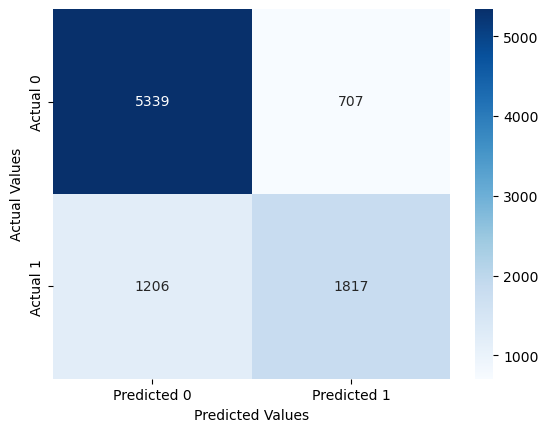

In [22]:
# Calling the function
confusion_matrix_data_modified(final_values,test.booking_status,0.45)

#### Overbooking formula

Currently, most hotels overbook anywhere between 2%, 3%, up to 10%, and 15%. The higher the overbooking percentage, the more likely a customer is to have to be rebooked to a different hotel. This would lead to customers dissatisfaction due to the constant moving pieces. 

The true positive rate is aroun 60%, which means that 60% of the customers predicted to cancel will cancel. To edge on the safer end, we would recommend overbooking approximately 50% the number of customers predicted to cancel for the night.

In addition, the true negative rate or the specificity of the model is 1 - FPR = ~90%, which means that approximately 90% of customers predicted to not cancel follow through with their reservation. This means that using our model, we will miss guess around 10% of customers who are going to follow through. Once again, to edge on the safer end, we would recommend overbooking approximately 2% the number of customers predicted to follow through for the night. This would be best for the hotel to maximizes the profit. 

In addition, we would recommend that the customer round down the number of rooms to overbook, just to edge on the safer side

In [48]:
# Function to give a model's tpr

from sklearn.metrics import roc_curve, auc

def confusion_matrix_data_modified_tpr(pred_values,actual_values,cutoff=0.5):
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    return tpr

In [49]:
test_tpr = confusion_matrix_data_modified_tpr(final_values,test.booking_status,0.45)
test_tpr

0.6010585511081707

In [50]:
# Function to give a model's tnr

from sklearn.metrics import roc_curve, auc

def confusion_matrix_data_modified_tnr(pred_values,actual_values,cutoff=0.5):
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tnr = 1 - fpr
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    return tnr

In [51]:
test_tnr = confusion_matrix_data_modified_tnr(final_values,test.booking_status,0.45)
test_tnr

0.8830631822692689

In [52]:
test_0_1 = test.booking_status.value_counts()
test_0_1.head()

0    6046
1    3023
Name: booking_status, dtype: int64

In [59]:
room_type_grouped = train.groupby('room_type_reserved')
room_type_mean_price = room_type_grouped.mean().avg_price_per_room
room_type_mean_price.min()

85.25

In [61]:
# Overbooking formula for the number of rooms they should overbook

def overbooking_formula(tpr, tnr, test_0_1, test):
    min_price = test.avg_price_per_room.min()
    max_price = test.avg_price_per_room.max()
    overbooking = test_0_1[1] * (tpr - 0.1) + test_0_1[0] * (1 - tnr - 0.1)
    lower = overbooking * min_price
    higher = overbooking * max_price
    print('The client should overbook', overbooking, 'rooms.')
    print('The client would save at least $', lower, 'and  $', )
    return overbooking, lower, higher

In [62]:
overbooking_formula(test_tpr, test_tnr, test_0_1, test)

(1617.1000000000001, 137857.77500000002, 296049.7412341041)